# Tests on how I handle sparsity. will move into a unit test file

In [1]:
import logging
import itertools as it
import os
import sys
import warnings
from time import perf_counter
def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)
    
#You don’t need those lines if you installed the packages
append_path("/home/tristan/research/ot_markov_distances/")
append_path("/home/tristan/research/ot_markov_distances/experiments")
append_path("/home/tristan/research/tb_ml/")
append_path("/home/tristan/research/FGW/lib")

logging.basicConfig(level=logging.INFO, force=True)

In [2]:
import torch
from torch import Tensor

In [3]:
from ml_lib.misc import all_equal
from ot_markov_distances import wl_reg_infty, sinkhorn
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov, densify

from utils.modules import ParametricMarkovMatrixWithMatchings
from utils.data_generation import circle_graph



In [4]:
# prepare fake test data
batch_size = 2
n1, n2 = 17, 23
test_sizes=[n1] * batch_size
test_graphs = [circle_graph(size, kind="nn", k=2) for size in test_sizes]
test_matrices = [weighted_transition_matrix(g, q=.1) for g in test_graphs]
mx = torch.stack(test_matrices)
test_sizes=[n2] * batch_size
test_graphs = [circle_graph(size, kind="nn", k=3) for size in test_sizes]
test_matrices = [weighted_transition_matrix(g, q=.1) for g in test_graphs]
my = torch.stack(test_matrices)


C = torch.rand((batch_size, n1, n2)) * 5

## stuff on MX

In [6]:
# max degree
mx_flat_degree = (mx_flat>0).sum(-1)
mx_max_degree = mx_flat_degree.max()
mx_max_degree


tensor(5)

In [7]:
# indices and padding masks
nonzero_indices = torch.zeros((*batch, n, mx_max_degree), dtype=torch.long)
nonzero_indices_mask = torch.zeros((*batch, n, mx_max_degree), dtype=bool)
nzi_flat = nonzero_indices.view(-1, mx_max_degree)
nzi_flat_mask = nonzero_indices_mask.view(-1, mx_max_degree)

for i in range(n_flat):
    line, = mx_flat[i].nonzero(as_tuple=True)
    line_len = len(line)
    nzi_flat[i, :line_len] = line
    nzi_flat_mask[i, :line_len] = 1


In [8]:
#densified
# we want mx_dense[*b, i, k] = mx[*b, i, nonzero_indices[*b, i, k]] if nonzero_indices_mask[*b, i, k] else 0
mx_dense = torch.empty((*batch, n, mx_max_degree))
mx_dense_flat = mx_dense.view((-1, mx_max_degree))
mx_dense_flat[...] = torch.where(nzi_flat_mask, mx_flat.gather(1, nzi_flat), 0)


In [9]:
mx_dense_flat

tensor([[0.1000, 0.3000, 0.3000, 0.3000, 0.0000],
        [0.4500, 0.1000, 0.4500, 0.0000, 0.0000],
        [0.3000, 0.3000, 0.1000, 0.3000, 0.0000],
        [0.1000, 0.3000, 0.3000, 0.3000, 0.0000],
        [0.1000, 0.4500, 0.4500, 0.0000, 0.0000],
        [0.1000, 0.4500, 0.4500, 0.0000, 0.0000],
        [0.2250, 0.1000, 0.2250, 0.2250, 0.2250],
        [0.4500, 0.1000, 0.4500, 0.0000, 0.0000],
        [0.2250, 0.2250, 0.1000, 0.2250, 0.2250],
        [0.4500, 0.1000, 0.4500, 0.0000, 0.0000],
        [0.4500, 0.1000, 0.4500, 0.0000, 0.0000],
        [0.3000, 0.1000, 0.3000, 0.3000, 0.0000],
        [0.3000, 0.3000, 0.3000, 0.1000, 0.0000],
        [0.3000, 0.3000, 0.3000, 0.1000, 0.0000],
        [0.3000, 0.3000, 0.3000, 0.1000, 0.0000],
        [0.4500, 0.1000, 0.4500, 0.0000, 0.0000],
        [0.3000, 0.3000, 0.3000, 0.1000, 0.0000],
        [0.1000, 0.2250, 0.2250, 0.2250, 0.2250],
        [0.1000, 0.4500, 0.4500, 0.0000, 0.0000],
        [0.4500, 0.1000, 0.4500, 0.0000, 0.0000],


In [10]:
mx_index2, mx_mask2, mx_dense2 =  densify(mx)


 ### Unit tests !

In [11]:
assert (mx_index2 ==  nonzero_indices).all()
assert (mx_mask2 == nonzero_indices_mask).all()

assert torch.allclose(mx_dense.sum(-1), torch.tensor(1.))

In [12]:
for b, i, j in it.product(*(range(i) for i in (*batch, n, mx_max_degree))):
    assert mx_dense2[b, i, j] == mx[b, i, mx_index2[b, i, j]] or not mx_mask2[b, i, j].item()

In [13]:
for b, i, j in it.product(*(range(i) for i in (*batch, n, n))):
    assert (mx[b, i, j].item() == 0) == (
        j not in mx_index2[b, i]
        or not mx_mask2[b, i, list(mx_index2[b, i]).index(j)]
    ) 

## Stuff on C

In [14]:
C = torch.rand((batch_size, n1, n2)) * 5

In [15]:
mx_index, mx_mask, mx_dense =  densify(mx)
my_index, my_mask, my_dense =  densify(my)
C.shape

torch.Size([2, 17, 23])

In [16]:
mx_index.shape

torch.Size([2, 17, 5])

In [17]:
my_index.shape

torch.Size([2, 23, 7])

In [18]:
# we’re assuming all this has already been broadcast to each other, so batches should be the same 
b, n, m = C.shape
b_, n_, dx = mx_index.shape
b__, m_, dy = my_index.shape
assert all_equal(b, b_, b__) and n == n_ and m == m_

In [19]:
C = C.contiguous()

C_index =  m * mx_index[:, :, None, :, None] +  my_index[:, None, :, None, :]
# b, n, m, dx, dy
C_index = C_index.reshape(b, n, m, dx*dy)
C_dense = C.view(b, n * m)[:, None, None, :]\
    .broadcast_to(b, n, m, n*m)\
    .gather(-1, C_index)\
    .reshape(b, n, m, dx, dy)
# believe me it works
# god I hate indices

for bi, ni, mi, i1, i2 in it.product(range(b), range(n), range(m), range(dx), range(dy)):
    #print(bi, ni, mi, i1, i2)
    assert C_dense[bi, ni, mi, i1, i2] == C[bi, mx_index[bi, ni, i1], my_index[bi, mi, i2]]
    
    

In [20]:
torch.arange(0, b * C.stride(0), step=C.stride(0)).shape

torch.Size([2])

In [21]:
C_index2 = C.stride(1) * mx_index[:, :, None, :, None] +  my_index[:, None, :, None, :] + torch.arange(0, b * C.stride(0), step=C.stride(0))[:, None, None, None, None]
C_index2.shape

(C.view(-1)[C_index2] == C_dense).all()

tensor(True)

In [22]:
C_mask = (mx_mask[:, :, None, :, None] & my_mask[:, None, :, None, :])
C_dense[C_mask == False] = 1.

In [23]:
torch.allclose(sinkhorn(mx_dense[:, :, None, :], my_dense[:, None, :, :], C_dense, epsilon=.1 ) , sinkhorn(mx[:, :, None, :], my[:, None, :, :], C[:, None, None, :, :], epsilon=.1), atol=1e-4, rtol=1e-2)

True

In [24]:
%%timeit
sinkhorn(mx_dense[:, :, None, :], my_dense[:, None, :, :], C_dense, epsilon=.1 )

4.73 s ± 83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit 
sinkhorn(mx[:, :, None, :], my[:, None, :, :], C[:, None, None, :, :], epsilon=.1)

23.6 s ± 4.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


That’s nice, isn’t it

In [26]:
%%script true

# this may be slightly more general, but it requires non contiguous reshaping, so we end up having to copy C.
# which kills the purpose

mx_index, mx_mask, mx_dense =  densify(mx)
my_index, my_mask, my_dense =  densify(my)
# we’re assuming all this has already been broadcast to each other, so batches should be the same 
mx_index = mx_index[:, :, None, :]
my_index = my_index[:, None, :, :]
mx_mask = mx_mask[:, :, None, :]
my_mask = my_mask[:, None, :, :]

C = C[:, None, None, :, :]
# we’re assuming all this has already been broadcast to each other, so batches should be the same 
*batch1, dx = mx_index.shape
*batch2, dy = my_index.shape
*batch3, n, m = C.shape
batch = torch.broadcast_shapes(batch1, batch2, batch3)

mx_index_flat = mx_index.expand(*batch, dx).reshape(-1, dx)
my_index_flat = my_index.expand(*batch, dy).reshape(-1, dy)
mx_mask_flat = mx_mask.expand(*batch, dx).reshape(-1, dx)
my_mask_flat = my_mask.expand(*batch, dy).reshape(-1, dy)
C_flat = C.expand(*batch, n, m).view(-1, n, m)

C_index_flat = m * mx_index_flat +  my_index_flat
C_dense_flat = C_flat.gather(-1, C_index_flat)


In [27]:
#getting stuff back
mx_test = torch.zeros_like(mx)
mx_test.scatter_add_(-1, mx_index, mx_dense)
(mx_test == mx).all()

tensor(True)

In [28]:
mx_index.shape

torch.Size([2, 17, 5])

In [29]:
C_index2.shape

torch.Size([2, 17, 23, 5, 7])

In [51]:
C_dense.shape

torch.Size([2, 17, 23, 5, 7])

In [50]:
C2 = torch.zeros(n, m, b, n, m).view(n, m, -1)
C2.index_add_(-1, C_index2.view(-1), C_dense.view(-1))

RuntimeError: index_add_(): Indexing dim 2 is out of bounds of the source tensor with dim 1

In [65]:
rpC.shape

torch.Size([17, 23, 782])

In [76]:
def re_project_C(C_dense, C_index, C_mask=None):
    b, n, m, dx, dy = C_dense.shape
    if C_mask is not None:
        C_dense = C_dense.clone()
        C_dense[C_mask==0]=0
    C_dense = torch.einsum("bijxy->ijbxy", C_dense)
    C_index = torch.einsum("bijxy->ijbxy", C_index)
    C = torch.zeros(n, m, b, n, m).view(n, m, -1) 
    C.scatter_add_(-1, C_index.reshape(n, m, -1), C_dense.reshape(n, m, -1))
    return torch.einsum("ijbxy->bijxy", C.view(n, m, b, n, m))
rpC = re_project_C(C_dense, C_index2, C_mask)
assert ((rpC == 0) | (rpC == C[:, None, None, ...])).all()

## Incorporate it into discounted WL

In [127]:
from ot_markov_distances.utils import densify, cost_matrix_index, reindex_cost_matrix
from ot_markov_distances.discounted_wl import DiscountedWlCostMatrix, double_last_dimension
from ot_markov_distances.sinkhorn import sinkhorn_internal

In [128]:
from ml_lib.misc import all_equal, debug_time
from ml_lib.pipeline.annealing_scheduler import get_scheduler
import torch
from torch import Tensor
from torch.nn import functional as F


In [1]:
class DiscountedWlCostMatrixSparse(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, MX: Tensor, MY: Tensor, 
        distance_matrix: Tensor,
        delta: float = .4,
        sinkhorn_reg: float=.01,
        max_iter: int = 50,
        convergence_threshold_rtol = 5e-3,
        convergence_threshold_atol = 1e-6,
        sinkhorn_iter: int= 100,
        return_differences: bool=False,
        sinkhorn_iter_scheduler="constant"
        ):
        """computes the regularized WL distance

        computes the regularized WL distance between two markov transition matrices 
        (represented as torch tensor)

        Batched over first dimension (b)
        
        delta can be a torch tensor (or a simple float). 
        please don’t modify it inplace between forward and backward, I don't check for that

        Args:
            MX: (b, n, n) first transition tensor
            MY: (b, m, m) second transition tensor
            l1: (b, n,) label values for the first space
            l2: (b, m,) label values for the second space
            k: number of steps (k parameter for the WL distance)
            muX: stationary distribution for MX (if omitted, will be recomuputed)
            muY: stationary distribution for MY (if omitted, will be recomuputed)
            reg: regularization parameter for sinkhorn
            delta: regularization parameter for WL
            sinkhorn_iter: number of sinkhorn iterations for a step
        """
        b, n, n_ = MX.shape
        b_, m, m_ = MY.shape
        b__, n__, m__  = distance_matrix.shape
        assert all_equal(n, n_, n__) and all_equal(m, m_, m__) and all_equal(b, b_, b__)
        assert max_iter >= 1, "Can’t really converge without iterating"
        one_minus_delta = 1 - delta
        scheduler = get_scheduler(sinkhorn_iter_scheduler, T_0=max_iter, beta_0=sinkhorn_iter)
        
        differences = []
        debug_time()
        with torch.no_grad():
            cost_matrix = delta * distance_matrix
            cost_matrix = cost_matrix.contiguous()
            mx_index, mx_mask, mx_dense = densify(MX)
            my_index, my_mask, my_dense = densify(MY)
            mx_dense = mx_dense[:, :, None, :] # b, n, 1, dx
            my_dense = my_dense[:, None, :, :] # b, 1, m, dy
            c_index, c_mask = cost_matrix_index(C, mx_index, my_index, mx_mask, my_mask)

            for _ in range(max_iter):
                # sinkhorn pass
                f, g, log_P = sinkhorn_internal(
                        mx_dense, # b, n, 1, dx
                        my_dense, # b, 1, m, dy
                        reindex_cost_matrix(C, c_index, c_mask), # b, n, m, dx, dy
                        epsilon=sinkhorn_reg, 
                        k= int(scheduler.step()) + 1
                )# f : (b, n, m, dx) , g:(b, n, m, dy), log_P:(b, n, m, dx, dy)
                sinkhorn_result = (f * mx_dense).sum(-1) + (g*my_dense).sum(-1)
                # update
                new_cost_matrix = delta * distance_matrix \
                    + one_minus_delta * sinkhorn_result # b, n, m
                new_cost_matrix = new_cost_matrix.contiguous()
                
                # stop condition 
                if torch.allclose(cost_matrix, new_cost_matrix, 
                            rtol=convergence_threshold_rtol,
                            atol=convergence_threshold_atol):
                    break
                differences.append(F.mse_loss(cost_matrix, new_cost_matrix))
                cost_matrix = new_cost_matrix 
                debug_time("iteration")
            else:
                warnings.warn("regularized WL did not converge")

        ctx.save_for_backward(f, g, log_P, mx_index, my_index, mx_mask, my_mask, c_index, c_mask) #type:ignore
        ctx.delta = delta
        ctx.one_minus_delta = one_minus_delta
        if return_differences:
            return cost_matrix, differences
        return cost_matrix
        
    @staticmethod
    def backward(ctx, grad_output):
        """
        See the paper for details on how the backward pass is computed.
        
        Args:
            grad_output: (b,)
        """
        f_dense, g_dense, log_P_dense, mx_index, my_index, mx_mask, my_mask, c_index, c_mask = ctx.saved_tensors
        b, n, m, dx, dy = log_P_dense.shape
        delta = ctx.delta
        one_minus_delta = ctx.one_minus_delta
        device = log_P_dense.device
        
        with torch.no_grad():
            #restore f, g, log_P to the right size            
            f = torch.zeros((b, n, m, n))\
                .scatter_add_(-1, mx_index[:, :, None, :].broadcast_to(b, n, m, dx), f_dense)
            g = torch.zeros((b, n, m, m))\
                .scatter_add_(-1, my_index[:, None, :, :].broadcast_to(b, n, m, dy), g_dense)
            #P_dense[c_mask == 0] = 0 # I dont think i actually want that. 
            P_dense= log_P_dense.exp()
            P = re_project_C(P_dense, c_index)    
            #P = log_P.exp() #b, n, m, n, m
            # f  (b, n, m, n)
            # F = torch.einsum("bijl->bijil", f) #doesnt work but that’s the idea
            F = torch.permute(f, (0, 2, 3, 1)) #bijl -> bjli
            F = double_last_dimension(F) #bjlii
            F = torch.permute(F, (0, 3, 1, 4, 2)) #bijil
            # (n, m, n, n)
            # g (b, n, m, m)
            # G = torch.einsum("bijl->bijjl", g) #(n, m, m, m)
            G = torch.permute(g, (0, 1, 3, 2)) #bijl -> bilj
            G = double_last_dimension(G) #biljj
            G = torch.permute(G, (0, 1, 3, 4, 2)) #bijjl 
        
            mymatrix = torch.eye(n*m, device=device)[None, ...] - one_minus_delta * P.reshape(b, n*m, n*m) 
            # b, n*m, n*m
            
            #print(torch.det(mymatrix))
            #print(mymatrix)
            #see paper for a proof this is diagonally dominant, thus invertible
            Delta = delta * torch.inverse(mymatrix)
            Gamma = one_minus_delta * torch.linalg.solve(mymatrix, F.reshape(b, n*m, n*n))
            Theta = one_minus_delta * torch.linalg.solve(mymatrix, G.reshape(b, n*m, m*m))
            
            Delta = Delta.reshape(b, n, m, n, m)
            Gamma = Gamma.reshape(b, n, m, n, n) 
            Theta = Theta.reshape(b, n, m, m, m)

            d_cost_matrix = torch.einsum("bijkl,bij->bkl", Delta, grad_output)
            d_mx = torch.einsum("bijkl,bij->bkl", Gamma, grad_output)
            d_my = torch.einsum("bijkl,bij->bkl", Theta, grad_output)
                        
            d_mx = d_mx - d_mx.mean(-1, keepdims=True)# normalize the markov gradients to stay in the markov space
            d_my = d_my - d_my.mean(-1, keepdims=True)        
        return (d_mx, d_my, d_cost_matrix, *[None]*8 )

mx = mx.detach().requires_grad_()
my = my.detach().requires_grad_()
C = C.detach().requires_grad_()

C_infty = DiscountedWlCostMatrixSparse.apply(mx, my, C)
C_infty.sum().backward()

mx_new_grad = mx.grad.detach().clone()
my_new_grad = my.grad.detach().clone()
C_new_grad = C.grad.detach().clone()

NameError: name 'torch' is not defined

In [ ]:
class DiscountedWlCostMatrixSparse(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, MX: Tensor, MY: Tensor, 
        distance_matrix: Tensor,
        delta: float = .4,
        sinkhorn_reg: float=.01,
        max_iter: int = 50,
        convergence_threshold_rtol = 5e-3,
        convergence_threshold_atol = 1e-6,
        sinkhorn_iter: int= 100,
        return_differences: bool=False,
        sinkhorn_iter_scheduler="constant"
        ):
        """computes the regularized WL distance

        computes the regularized WL distance between two markov transition matrices 
        (represented as torch tensor)

        Batched over first dimension (b)
        
        delta can be a torch tensor (or a simple float). 
        please don’t modify it inplace between forward and backward, I don't check for that

        Args:
            MX: (b, n, n) first transition tensor
            MY: (b, m, m) second transition tensor
            l1: (b, n,) label values for the first space
            l2: (b, m,) label values for the second space
            k: number of steps (k parameter for the WL distance)
            muX: stationary distribution for MX (if omitted, will be recomuputed)
            muY: stationary distribution for MY (if omitted, will be recomuputed)
            reg: regularization parameter for sinkhorn
            delta: regularization parameter for WL
            sinkhorn_iter: number of sinkhorn iterations for a step
        """
        b, n, n_ = MX.shape
        b_, m, m_ = MY.shape
        b__, n__, m__  = distance_matrix.shape
        assert all_equal(n, n_, n__) and all_equal(m, m_, m__) and all_equal(b, b_, b__)
        assert max_iter >= 1, "Can’t really converge without iterating"
        one_minus_delta = 1 - delta
        scheduler = get_scheduler(sinkhorn_iter_scheduler, T_0=max_iter, beta_0=sinkhorn_iter)
        
        differences = []
        debug_time()
        with torch.no_grad():
            cost_matrix = delta * distance_matrix
            cost_matrix = cost_matrix.contiguous()
            mx_index, mx_mask, mx_dense = densify(MX)
            my_index, my_mask, my_dense = densify(MY)
            mx_dense = mx_dense[:, :, None, :] # b, n, 1, dx
            my_dense = my_dense[:, None, :, :] # b, 1, m, dy
            c_index, c_mask = cost_matrix_index(C, mx_index, my_index, mx_mask, my_mask)

            for _ in range(max_iter):
                # sinkhorn pass
                sinkhorn_result = sinkhorn(
                        mx_dense, # b, n, 1, dx
                        my_dense, # b, 1, m, dy
                        reindex_cost_matrix(C, c_index, c_mask), # b, n, m, dx, dy
                        epsilon=sinkhorn_reg, 
                        k= int(scheduler.step()) + 1
                )
                # update
                new_cost_matrix = delta * distance_matrix \
                    + one_minus_delta * sinkhorn_result # b, n, m
                new_cost_matrix = new_cost_matrix.contiguous()
                
                # stop condition 
                if torch.allclose(cost_matrix, new_cost_matrix, 
                            rtol=convergence_threshold_rtol,
                            atol=convergence_threshold_atol):
                    break
                differences.append(F.mse_loss(cost_matrix, new_cost_matrix))
                cost_matrix = new_cost_matrix
                debug_time("iteration")
            else:
                warnings.warn("regularized WL did not converge")

        ctx.save_for_backward(f, g, log_P, mx_index, my_index, mx_mask, my_mask, c_index, c_mask) #type:ignore
        ctx.delta = delta
        ctx.one_minus_delta = one_minus_delta
        if return_differences:
            return cost_matrix, differences
        return cost_matrix
        
    @staticmethod
    def backward(ctx, grad_output):
        """
        See the paper for details on how the backward pass is computed.
        
        Args:
            grad_output: (b,)
        """
        f_dense, g_dense, log_P_dense, mx_index, my_index, mx_mask, my_mask, c_index, c_mask = ctx.saved_tensors
        b, n, m, dx, dy = log_P_dense.shape
        delta = ctx.delta
        one_minus_delta = ctx.one_minus_delta
        device = log_P_dense.device
        
        with torch.no_grad():
            #restore f, g, log_P to the right size            
            f = torch.zeros((b, n, m, n))\
                .scatter_add_(-1, mx_index[:, :, None, :].broadcast_to(b, n, m, dx), f_dense)
            g = torch.zeros((b, n, m, m))\
                .scatter_add_(-1, my_index[:, None, :, :].broadcast_to(b, n, m, dy), g_dense)
            #P_dense[c_mask == 0] = 0 # I dont think i actually want that. 
            P_dense= log_P_dense.exp()
            P = re_project_C(P_dense, c_index)    
            #P = log_P.exp() #b, n, m, n, m
            # f  (b, n, m, n)
            # F = torch.einsum("bijl->bijil", f) #doesnt work but that’s the idea
            F = torch.permute(f, (0, 2, 3, 1)) #bijl -> bjli
            F = double_last_dimension(F) #bjlii
            F = torch.permute(F, (0, 3, 1, 4, 2)) #bijil
            # (n, m, n, n)
            # g (b, n, m, m)
            # G = torch.einsum("bijl->bijjl", g) #(n, m, m, m)
            G = torch.permute(g, (0, 1, 3, 2)) #bijl -> bilj
            G = double_last_dimension(G) #biljj
            G = torch.permute(G, (0, 1, 3, 4, 2)) #bijjl 
        
            mymatrix = torch.eye(n*m, device=device)[None, ...] - one_minus_delta * P.reshape(b, n*m, n*m) 
            # b, n*m, n*m
            
            #print(torch.det(mymatrix))
            #print(mymatrix)
            #see paper for a proof this is diagonally dominant, thus invertible
            Delta = delta * torch.inverse(mymatrix)
            Gamma = one_minus_delta * torch.linalg.solve(mymatrix, F.reshape(b, n*m, n*n))
            Theta = one_minus_delta * torch.linalg.solve(mymatrix, G.reshape(b, n*m, m*m))
            
            Delta = Delta.reshape(b, n, m, n, m)
            Gamma = Gamma.reshape(b, n, m, n, n) 
            Theta = Theta.reshape(b, n, m, m, m)

            d_cost_matrix = torch.einsum("bijkl,bij->bkl", Delta, grad_output)
            d_mx = torch.einsum("bijkl,bij->bkl", Gamma, grad_output)
            d_my = torch.einsum("bijkl,bij->bkl", Theta, grad_output)
                        
            d_mx = d_mx - d_mx.mean(-1, keepdims=True)# normalize the markov gradients to stay in the markov space
            d_my = d_my - d_my.mean(-1, keepdims=True)        
        return (d_mx, d_my, d_cost_matrix, *[None]*8 )

mx = mx.detach().requires_grad_()
my = my.detach().requires_grad_()
C = C.detach().requires_grad_()

C_infty = DiscountedWlCostMatrixSparse.apply(mx, my, C)
C_infty.sum().backward()

mx_new_grad = mx.grad.detach().clone()
my_new_grad = my.grad.detach().clone()
C_new_grad = C.grad.detach().clone()

In [151]:
mx = mx.detach().requires_grad_()
my = my.detach().requires_grad_()
C = C.detach().requires_grad_()
C_infty2 = DiscountedWlCostMatrix.apply(mx, my, C)
C_infty2.sum().backward()

INFO:root:iteration: time elapsed 1.5979630313813686s
INFO:root:iteration: time elapsed 1.5599573720246553s
INFO:root:iteration: time elapsed 1.2026522997766733s
INFO:root:iteration: time elapsed 1.4931569267064333s
INFO:root:iteration: time elapsed 1.4285323228687048s
INFO:root:iteration: time elapsed 1.390657739713788s
INFO:root:iteration: time elapsed 1.5235140081495047s
INFO:root:iteration: time elapsed 1.3720796387642622s
INFO:root:iteration: time elapsed 1.358828354626894s
INFO:root:iteration: time elapsed 1.4717292338609695s


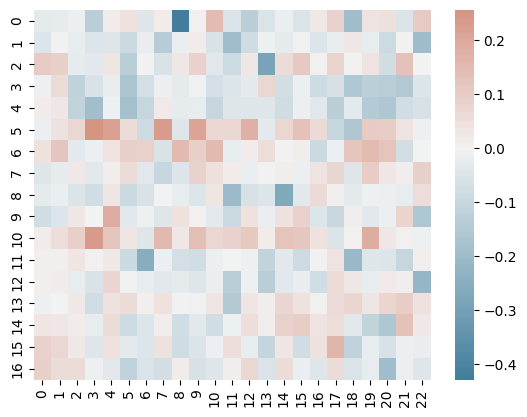

In [152]:
import seaborn as sns
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap((C_infty[0]-  C_infty2[0]) / C_infty[0], center = 0, cmap=cmap)

In [153]:
mx_grad = mx.grad.detach().clone()
my_grad = my.grad.detach().clone()
C_grad = C.grad.detach().clone()

In [160]:
mx_grad[0, 0]

tensor([ -4.3255,  -8.3788,   8.8664,  -9.1317,  -8.6410, -11.0822,  -5.8388,
          5.5822,  10.1769,   4.7544,   0.4675,  10.0877,  -9.7420, -10.1103,
          6.4100,   4.1171,  16.7880])

In [161]:
mx_new_grad[0, 0]

tensor([ 0.6936, -7.0199, -7.0199, -7.0199, -7.0199, -7.0199, -7.0199, -7.0199,
        36.7321, -7.0199, -7.0199, 35.0043, -7.0199, -7.0199, -7.0199, 18.8289,
        -7.0199])

In [166]:
a = mx[0, 0]

In [167]:
b = my[0, 0]

In [180]:
a_dense = mx_dense[0, 0]
b_dense = my_dense[0, 0]
C_test = C_dense[0, 0, 0]

In [178]:
sinkhorn(a, b, C[0], epsilon=.1)

tensor(1.1836, grad_fn=<SinkhornBackward>)

In [181]:
sinkhorn(a_dense, b_dense, C_test, epsilon=.1)

tensor(1.1836)

In [183]:
f_test, g_test, lP_test = sinkhorn_internal(a, b, C[0], epsilon=.1)
f_test2, g_test2, lP_test2 = sinkhorn_internal(a_dense, b_dense, C_test, epsilon=.1)


In [184]:
f_test

tensor([ 1.6038,  0.6738,  1.3214, -0.6177,  0.5780,  0.0400, -0.5445,  1.1845,
         1.2837, -0.3121,  0.1945,  0.7306, -1.2066,  0.6633,  1.4521, -0.2891,
         1.5098], grad_fn=<MulBackward0>)

In [189]:
f_test2_z = f_test2.clone()
f_test2_z[mx_mask[0, 0] == 0] = 0.

In [190]:
torch.zeros_like(f_test).index_add(0, mx_index[0, 0], f_test2_z )

tensor([ 1.6497,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.3296,  0.0000,  0.0000,  0.7765,  0.0000,  0.0000,  0.0000, -0.2433,
         0.0000])

In [187]:
mx_index[0, 0]

tensor([ 0,  8, 11, 15,  0])

In [188]:
f_test2

tensor([ 1.6497,  1.3296,  0.7765, -0.2433, -0.5727])